In [94]:
import warnings
warnings.filterwarnings("ignore")
import modulesForCalibration_VG_XI as mfc
import matplotlib.pyplot as plt

import readPlotOptionSurface_granular_typeXII as marketSurface 
import readPlotOptionSurface_o
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sympy import *
from scipy.stats import norm

from matplotlib import cm
import cmath
import math
from scipy.optimize import fmin

import plotly.plotly as py
import plotly.graph_objs as go

# Pull in Market Prices: CALLS

## APPL

### deltaK = 1 & deltaTau = 1/52

#### ... too granular for computation ! 

### deltaK = 2.5 & deltaTau = 1/52

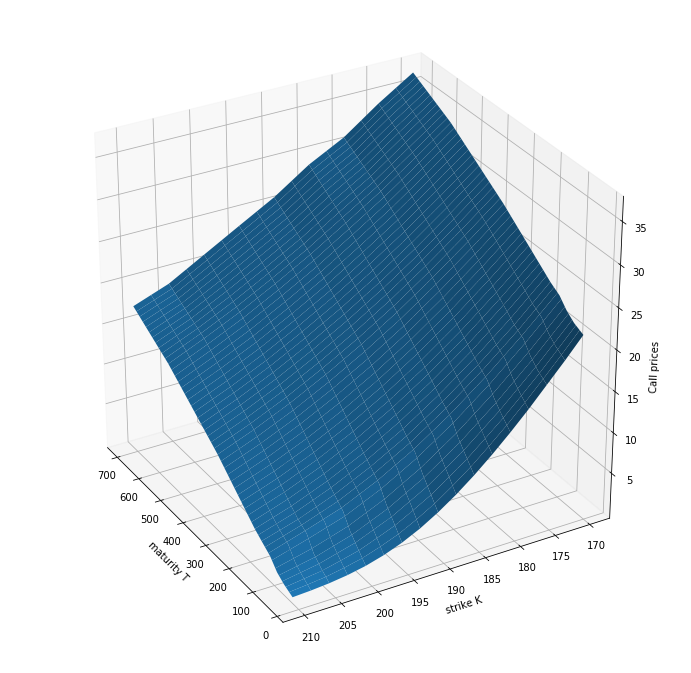

In [100]:
maturities, strikes, marketPrices, marketPricesNaN = marketSurface.readNPlot('APPL', 'Call')
maturities_years = maturities/365

# I. Model Prices

### Global Parameters

In [102]:
# Contract Parameters
S0 = 190
K = 190
k = np.log(K)
# risk free rate
r = 0.0245
# dividend rate
q = 0.005

# Parameters
alpha = 1.5                     
eta = 0.2

n = 10
N = 2**n

## 1. Finding a starting point  

***How to find a first promising starting point?: Run RMSE on less granular market prices to get general sense***

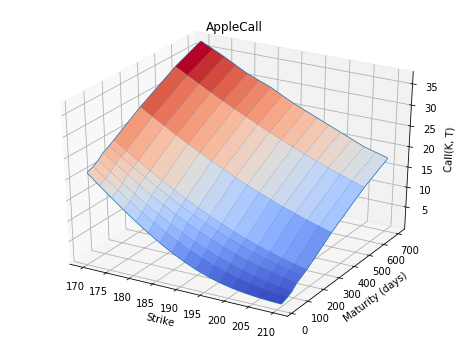

In [182]:
maturities, strikes, marketPrices = readPlotOptionSurface_o.readNPlot()
maturities_years = maturities/365

### Model specific parameters:

#### Heston 

In [103]:
model = 'Heston'

#set 1: promising starting point          BUT HOW TO FIND THESE IN THE FIRST PLACE?
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)
params2 = (3.0, 0.06, 0.10, -0.6, 0.04)

#### VGSA

In [60]:
model = 'VGSA'

"""""
sig = 0.1022
nu = 0.1819
theta = -0.0761
kappa  = 8.1143
eta    = 2.8060
lda    = 10.3646

params = []
params.append(sig)
params.append(nu)
params.append(theta)
params.append(kappa)
params.append(eta)
params.append(lda)

params
"""""
#set 1: promising starting point          BUT HOW TO FIND THESE IN THE FIRST PLACE?
params1 = (0.1022, 0.1819, -0.0761, 8.1143, 2.8060, 10.3646)
params2 = (3.1022, 1.1819, -1.0761, 4.1143, 0.8060, 5.3646)

#### VGSSD

In [80]:
model = 'VGSSD'

"""""
sig = 0.1022
nu = 0.1819
theta = -0.0761
kappa  = 8.1143
eta    = 2.8060
lda    = 10.3646

params = []
params.append(sig)
params.append(nu)
params.append(theta)
params.append(kappa)
params.append(eta)
params.append(lda)
"""""

#set 1: promising starting point          BUT HOW TO FIND THESE IN THE FIRST PLACE?
params1 = (0.1022, 0.1819, -0.0761, 8.1143, 2.8060, 10.3646, 0.5)
params2 = (3.1022, 1.1819, -1.0761, 4.1143, 0.8060, 5.3646, 1.3)

#### Test if FFT works with these models by constructing Price Surface w/ random parameters

In [81]:
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params1, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]

In [82]:
modelPrices.shape

(97, 17)

In [83]:
marketPrices.shape

(97, 17)

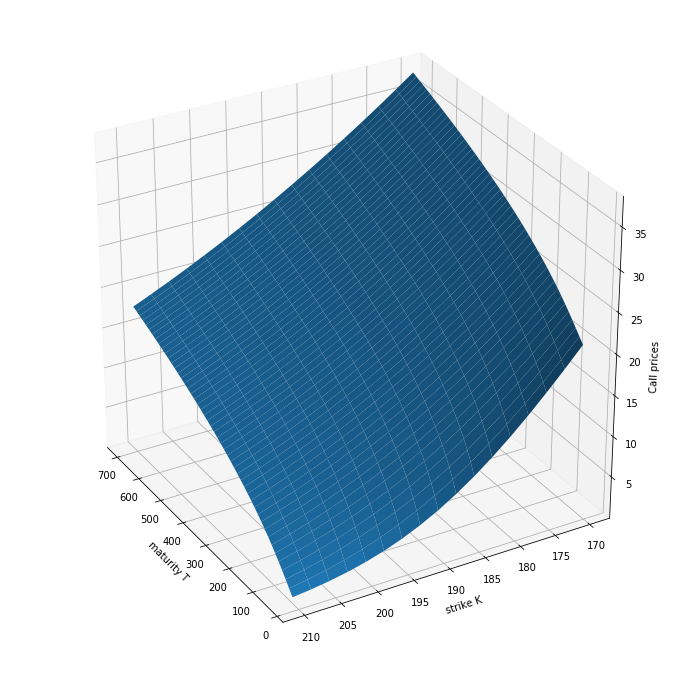

In [53]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(maturities, strikes)
ax.plot_surface(X, Y, modelPrices.transpose())
ax.set_xlabel('maturity T')
ax.set_ylabel('strike K')
ax.set_zlabel('Call prices')
ax.view_init(30, 150)
plt.show()

* Calculations use the form (marketPrices.transpose()) ---> (maturities, strikes) 

In [84]:
lenT = len(maturities_years)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

In [85]:
modelPrices.shape == marketPrices.shape

True

In [86]:
iArray = []                             # The alphas (0,1) which are plotted agains RMSE -> calling it i instead here
rmseArray = []
rmseMin = 1e10                          # Random; in order to have an error to start with

In [87]:
for i in mfc.myRange(-1, 1, 0.2):
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

In [88]:
len(rmseArray) == len(iArray)

True

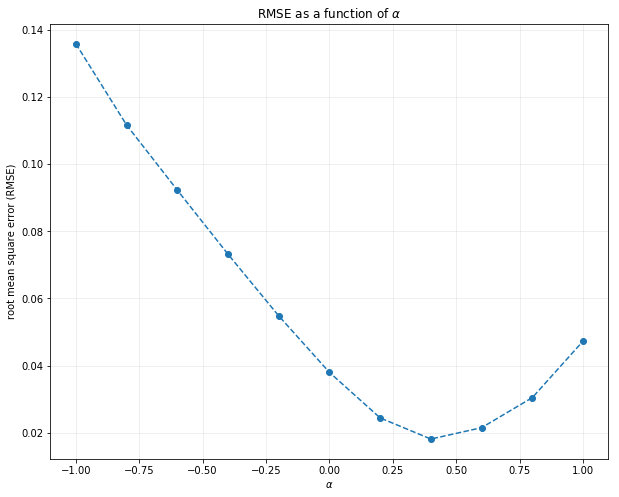

0.018150851420626134
[ 2.2    0.044  0.08  -0.52   0.056]


In [59]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')       #(This example: HESTON)
plt.title('RMSE as a function of $\\alpha$')
plt.savefig('startingPoint4.png')
plt.show()

print(rmseMin)
print(optimParams)

## 2. Optimization of Parameter Set

#### - Objective Function -

In [ ]:
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

In [459]:
lenT = len(maturities)
lenK = len(strikes)

*** Transposing marketPrices again (!) ***

In [460]:
marketPrices = (marketPrices.transpose())

In [44]:
marketPrices.shape

(97, 45)

#### A) Brute Force Algorithm

In [260]:
# maturities, strikes, marketPrices = marketSurface.readNPlot()

#==========================================
# Grid Search around the starting point
#------------------------------------------
# [ 2.2    0.044  0.08  -0.52   0.056]
ind_iter = 1
rmseMin = 1.0e6

for kappa in mfc.myRange(1.7,2.7,0.5):
    for theta in mfc.myRange(0.034,0.054,0.01):
        for sig in mfc.myRange(0.0700,0.0900,0.01):
            for rho in mfc.myRange(-0.62,-0.42,0.1):
                for v0 in mfc.myRange(0.046,0.066,0.01):
                    params = []
                    params.append(kappa)
                    params.append(theta)
                    params.append(sig)
                    params.append(rho)
                    params.append(v0)
                    
                    print('i = ' + str(ind_iter))
                    ind_iter += 1
                    print(params)
                    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
                    
                    if (rmse < rmseMin):
                        rmseMin = rmse
                        params2 = params
                        print('\nnew min found')
                        print(rmseMin)
                        print(params2)
                        print('')

print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

i = 1
[1.7, 0.034, 0.07, -0.62, 0.046]

new min found
1.0587390070549674
[1.7, 0.034, 0.07, -0.62, 0.046]

i = 2
[1.7, 0.034, 0.07, -0.62, 0.056]

new min found
0.6832649692677247
[1.7, 0.034, 0.07, -0.62, 0.056]

i = 3
[1.7, 0.034, 0.07, -0.62, 0.066]
i = 4
[1.7, 0.034, 0.07, -0.52, 0.046]
i = 5
[1.7, 0.034, 0.07, -0.52, 0.056]
i = 6
[1.7, 0.034, 0.07, -0.52, 0.066]
i = 7
[1.7, 0.034, 0.07, -0.42000000000000004, 0.046]
i = 8
[1.7, 0.034, 0.07, -0.42000000000000004, 0.056]
i = 9
[1.7, 0.034, 0.07, -0.42000000000000004, 0.066]
i = 10
[1.7, 0.034, 0.08, -0.62, 0.046]
i = 11
[1.7, 0.034, 0.08, -0.62, 0.056]
i = 12
[1.7, 0.034, 0.08, -0.62, 0.066]
i = 13
[1.7, 0.034, 0.08, -0.52, 0.046]
i = 14
[1.7, 0.034, 0.08, -0.52, 0.056]
i = 15
[1.7, 0.034, 0.08, -0.52, 0.066]
i = 16
[1.7, 0.034, 0.08, -0.42000000000000004, 0.046]
i = 17
[1.7, 0.034, 0.08, -0.42000000000000004, 0.056]
i = 18
[1.7, 0.034, 0.08, -0.42000000000000004, 0.066]
i = 19
[1.7, 0.034, 0.09, -0.62, 0.046]
i = 20
[1.7, 0.034, 0.0

i = 145
[2.2, 0.054000000000000006, 0.08, -0.62, 0.046]
i = 146
[2.2, 0.054000000000000006, 0.08, -0.62, 0.056]
i = 147
[2.2, 0.054000000000000006, 0.08, -0.62, 0.066]
i = 148
[2.2, 0.054000000000000006, 0.08, -0.52, 0.046]
i = 149
[2.2, 0.054000000000000006, 0.08, -0.52, 0.056]
i = 150
[2.2, 0.054000000000000006, 0.08, -0.52, 0.066]
i = 151
[2.2, 0.054000000000000006, 0.08, -0.42000000000000004, 0.046]
i = 152
[2.2, 0.054000000000000006, 0.08, -0.42000000000000004, 0.056]
i = 153
[2.2, 0.054000000000000006, 0.08, -0.42000000000000004, 0.066]
i = 154
[2.2, 0.054000000000000006, 0.09, -0.62, 0.046]
i = 155
[2.2, 0.054000000000000006, 0.09, -0.62, 0.056]
i = 156
[2.2, 0.054000000000000006, 0.09, -0.62, 0.066]
i = 157
[2.2, 0.054000000000000006, 0.09, -0.52, 0.046]
i = 158
[2.2, 0.054000000000000006, 0.09, -0.52, 0.056]
i = 159
[2.2, 0.054000000000000006, 0.09, -0.52, 0.066]
i = 160
[2.2, 0.054000000000000006, 0.09, -0.42000000000000004, 0.046]
i = 161
[2.2, 0.054000000000000006, 0.09, -0

#### - Market vs. Model Surface -

In [13]:
params2

(3.0, 0.06, 0.1, -0.6, 0.04)

In [242]:
params2 = [3.0, 0.06, 0.1, -0.6, 0.04]

In [244]:
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]

In [273]:
modelPrices.shape == marketPrices.shape

True

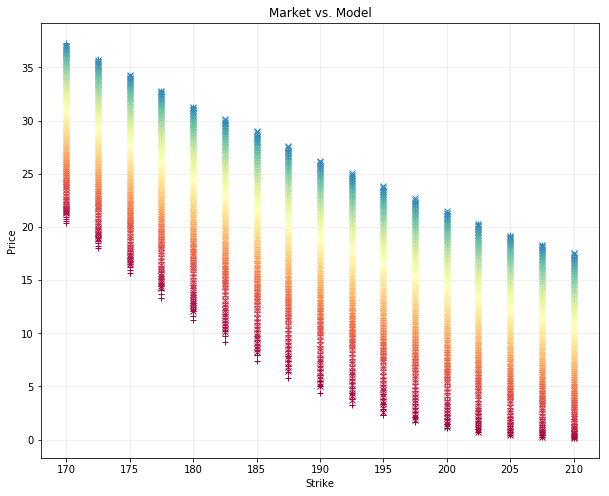

In [275]:
# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
    
#plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model')
plt.savefig('MarketvsModel_GridSearch.png')
plt.show() 

Good fit for long maturities, but not for short term:
29 cents

#### B) Nelder Mead Algorithm  (Gradient-free)

In [91]:
optimParams.tolist()

[0.1022, 0.1819, -0.0761, 8.1143, 2.806, 10.3646, 0.5]

In [92]:
#==========================================
# Nelder-Mead Simplex Algorithm -- fmin
#==========================================

params = optimParams.tolist()

def callbackF(xi):
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        mfc.eValue, 
        params, 
        args=arg, 
        xtol=1e-4,
        ftol=1e-4,
        maxiter=200,
        maxfun=400,
        callback=callbackF,
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

i = 1
x_i = [ 0.10439     0.18579786 -0.06849     8.28817786  2.86612857 10.58669857
  0.51071429]
f_i = 0.3231411019247291
i = 2
x_i = [ 0.10439     0.18579786 -0.06849     8.28817786  2.86612857 10.58669857
  0.51071429]
f_i = 0.3231411019247291
i = 3
x_i = [ 0.10439     0.18579786 -0.06849     8.28817786  2.86612857 10.58669857
  0.51071429]
f_i = 0.3231411019247291
i = 4
x_i = [ 0.10439     0.18579786 -0.06849     8.28817786  2.86612857 10.58669857
  0.51071429]
f_i = 0.3231411019247291
i = 5
x_i = [ 0.10439     0.18579786 -0.06849     8.28817786  2.86612857 10.58669857
  0.51071429]
f_i = 0.3231411019247291
i = 6
x_i = [ 0.11074917  0.17502833 -0.06718778  8.28208432  2.81353441 10.15266349
  0.54182568]
f_i = 0.3095643805285811
i = 7
x_i = [ 0.11074917  0.17502833 -0.06718778  8.28208432  2.81353441 10.15266349
  0.54182568]
f_i = 0.3095643805285811
i = 8
x_i = [ 0.11074917  0.17502833 -0.06718778  8.28208432  2.81353441 10.15266349
  0.54182568]
f_i = 0.3095643805285811
i = 9
x_

f_i = 0.03675996792330592
i = 66
x_i = [ 0.15845604  0.18287079  0.02140882  9.62634622  3.05500305 10.19300164
  0.71897415]
f_i = 0.03675996792330592
i = 67
x_i = [ 0.15748077  0.18364395  0.0223489   9.4241003   3.20822237 10.32565172
  0.70103564]
f_i = 0.034711304085759086
i = 68
x_i = [ 0.15748077  0.18364395  0.0223489   9.4241003   3.20822237 10.32565172
  0.70103564]
f_i = 0.034711304085759086
i = 69
x_i = [ 0.15748077  0.18364395  0.0223489   9.4241003   3.20822237 10.32565172
  0.70103564]
f_i = 0.034711304085759086
i = 70
x_i = [ 0.15949363  0.18167638  0.01997544  9.36225605  3.31657644 10.09146318
  0.68213949]
f_i = 0.03264915368491953
i = 71
x_i = [ 0.15949363  0.18167638  0.01997544  9.36225605  3.31657644 10.09146318
  0.68213949]
f_i = 0.03264915368491953
i = 72
x_i = [ 0.15949363  0.18167638  0.01997544  9.36225605  3.31657644 10.09146318
  0.68213949]
f_i = 0.03264915368491953
i = 73
x_i = [ 0.15949363  0.18167638  0.01997544  9.36225605  3.31657644 10.09146318
  0

i = 126
x_i = [ 1.98734876e-01  1.40139331e-01 -3.53923777e-03  5.99678076e+00
  4.97369920e+00  9.30186642e+00  4.86428491e-01]
f_i = 0.006176549996123671
i = 127
x_i = [ 1.98734876e-01  1.40139331e-01 -3.53923777e-03  5.99678076e+00
  4.97369920e+00  9.30186642e+00  4.86428491e-01]
f_i = 0.006176549996123671
i = 128
x_i = [ 1.98734876e-01  1.40139331e-01 -3.53923777e-03  5.99678076e+00
  4.97369920e+00  9.30186642e+00  4.86428491e-01]
f_i = 0.006176549996123671
i = 129
x_i = [ 1.98734876e-01  1.40139331e-01 -3.53923777e-03  5.99678076e+00
  4.97369920e+00  9.30186642e+00  4.86428491e-01]
f_i = 0.006176549996123671
i = 130
x_i = [ 1.98734876e-01  1.40139331e-01 -3.53923777e-03  5.99678076e+00
  4.97369920e+00  9.30186642e+00  4.86428491e-01]
f_i = 0.006176549996123671
i = 131
x_i = [ 1.98734876e-01  1.40139331e-01 -3.53923777e-03  5.99678076e+00
  4.97369920e+00  9.30186642e+00  4.86428491e-01]
f_i = 0.006176549996123671
i = 132
x_i = [ 1.98734876e-01  1.40139331e-01 -3.53923777e-03  

f_i = 0.0061131652950598865
i = 179
x_i = [ 1.98474093e-01  1.39564256e-01 -2.98389952e-03  6.04049458e+00
  4.96948941e+00  9.33359072e+00  4.87486577e-01]
f_i = 0.0061131652950598865
i = 180
x_i = [ 1.98474093e-01  1.39564256e-01 -2.98389952e-03  6.04049458e+00
  4.96948941e+00  9.33359072e+00  4.87486577e-01]
f_i = 0.0061131652950598865
i = 181
x_i = [ 1.98474093e-01  1.39564256e-01 -2.98389952e-03  6.04049458e+00
  4.96948941e+00  9.33359072e+00  4.87486577e-01]
f_i = 0.0061131652950598865
i = 182
x_i = [ 1.98474093e-01  1.39564256e-01 -2.98389952e-03  6.04049458e+00
  4.96948941e+00  9.33359072e+00  4.87486577e-01]
f_i = 0.0061131652950598865
i = 183
x_i = [ 1.98474093e-01  1.39564256e-01 -2.98389952e-03  6.04049458e+00
  4.96948941e+00  9.33359072e+00  4.87486577e-01]
f_i = 0.0061131652950598865
i = 184
x_i = [ 1.98474093e-01  1.39564256e-01 -2.98389952e-03  6.04049458e+00
  4.96948941e+00  9.33359072e+00  4.87486577e-01]
f_i = 0.0061131652950598865
i = 185
x_i = [ 1.98455004e-01

In [ ]:
"""""
___________________________________________

Optimized parameter set for each model: NM
___________________________________________


--Heston--

APPL: [ 3.82879801,  0.04661798,  0.14376313, -0.89199663,  0.03933305]
Error: 0.006112969304084599

--VGSA--

APPL: [ 0.12136109  0.29394931 -0.0313423   7.05843985  3.41100886  9.57625977] # 0.04
Error: 0.006112969304084599

--VGSSD--

APPL: [ 1.98498105e-01,  1.39458850e-01, -3.01231915e-03,  6.03921525e+00, 4.96902993e+00,  9.33313795e+00,  4.87477677e-01]
Error: 0.006112969304084599

#### - Market vs. Model Surface -

In [104]:
params_NM = [ 3.82879801,  0.04661798,  0.14376313, -0.89199663,  0.03933305]
lenT = len(maturities)
lenK = len(strikes)
modelPrices_MN = np.zeros((lenT, lenK))

for i in range(lenT): # do this to avoid interpolation error
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params_NM, S0, K, r, q, T, alpha, eta, n, model='Heston')
        modelPrices_MN[i,j] = cT_km[0]

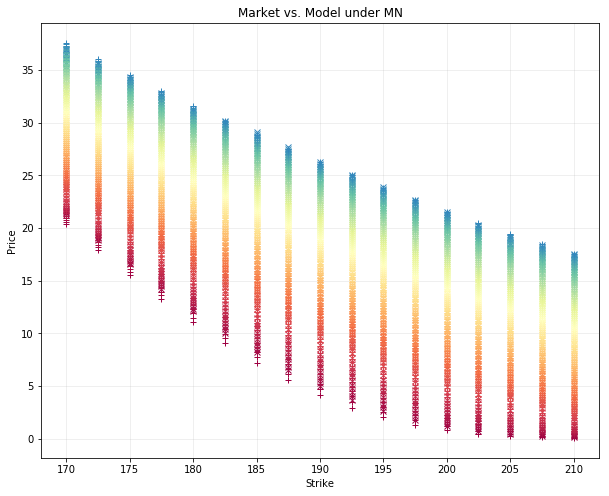

In [319]:
# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_MN[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
#plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model under MN')
#plt.savefig('MarketvsModel_NelderMead.png')
plt.show() 

### Evaluate which Optimization yields best results: Loss Function

In [320]:
# set 1: Brute-Force vs. Nelder-Mead
params_BF = [1.7, 0.044000000000000004, 0.09, -0.62, 0.046]
params_NM = [ 3.82879801,  0.04661798,  0.14376313, -0.89199663,  0.03933305]

# set 2: Brute-Force vs. BFGS
#params1 = (1.8, 0.046, 0.0925, -0.63, 0.044)
#params2 = (3.6941,  0.0478,  0.6059, -0.2186,  0.0422)

# set 2: NelderMead vs. BFGS
#params1 = (1.9524,  0.0469,  0.1159, -0.7406,  0.0397)
#params2 = (3.6941,  0.0478,  0.6059, -0.2186,  0.0422)

In [321]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.05):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_NM)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[ 4.89319702  0.04792697  0.1706447  -1.02799494  0.03599957]

-0.45
[ 4.78675711  0.04779607  0.16795654 -1.01439511  0.03633292]

-0.4
[ 4.68031721  0.04766517  0.16526838 -1.00079528  0.03666627]

-0.35000000000000003
[ 4.57387731  0.04753427  0.16258023 -0.98719545  0.03699962]

-0.30000000000000004
[ 4.46743741  0.04740337  0.15989207 -0.97359562  0.03733297]

-0.25000000000000006
[ 4.36099751  0.04727248  0.15720391 -0.95999579  0.03766631]

-0.20000000000000007
[ 4.25455761  0.04714158  0.15451576 -0.94639596  0.03799966]

-0.15000000000000008
[ 4.14811771  0.04701068  0.1518276  -0.93279612  0.03833301]

-0.10000000000000007
[ 4.04167781  0.04687978  0.14913944 -0.91919629  0.03866635]

-0.05000000000000007
[ 3.93523791  0.04674888  0.14645129 -0.90559646  0.0389997 ]

-6.938893903907228e-17
[ 3.82879801  0.04661798  0.14376313 -0.89199663  0.03933305]

0.04999999999999993
[ 3.72235811  0.04648708  0.14107497 -0.8783968   0.0396664 ]

0.09999999999999994
[ 3.61591821  0.0

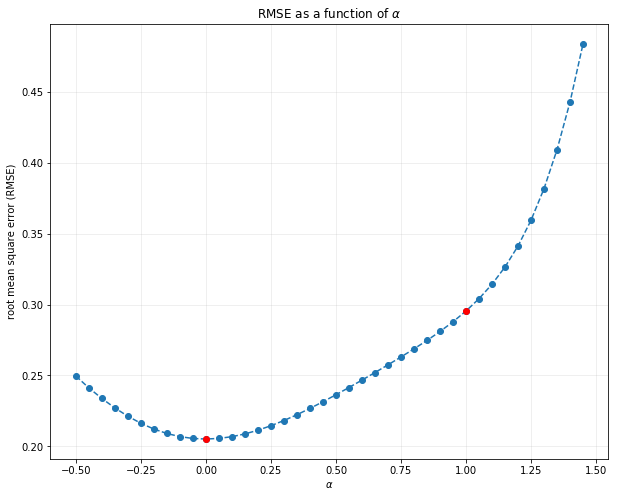

In [322]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.plot(iArray[10], rmseArray[10], 'ro')
plt.plot(iArray[30], rmseArray[30], 'ro')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
plt.savefig('NelderMeadvsBruteForce.png')
plt.show()

***Concludes that NM Parameters yield better result ***

## 3. Plot Model Price Surface 

In [386]:
data = [go.Surface(z=modelPrices.tolist(), colorscale='Viridis'), 
        go.Surface(z=marketPrices.tolist(), colorscale='Portland', showscale=False, opacity=0.5)]

layout = go.Layout(
    width=800,
    height=700,
    autosize=False,
    title='Calibrated Call Premium Surface Heston',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    )
)

fig = dict(data=data, layout=layout)

In [387]:
py.iplot(fig, filename='Calibrated-Call-Premium-Surface-Heston')

# II. Implied Volatility Surface from Calibrated Model Prices

In [109]:
cp = 'c'
modelPrices = modelPrices_MN
n = norm.pdf
N = norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (math.log10(S/K)+(r+(v**2)/2.)*T)/(v*T**0.5)
    d2 = d1-v*T**0.5
    if cp_flag == 'c':
        price = S*np.exp(-q*T)*N(d1)-K*np.exp(-r*T)*N(d2)
    else:
        price = K*np.exp(-r*T)*N(-d2)-S*np.exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (math.log10(S/K)+(r+v*v/2.)*T)/(v*math.sqrt(T))
    vega = S * math.sqrt(T)*n(d1)
    vega
    return vega

def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in range(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = float(target_value) - float(price)  # our root

        #print (i, sigma, diff)

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

def implied_vol_surface(S,r,cp,prices, maturities, strikes):
    lenT = len(maturities)
    lenK = len(strikes)
    IV = np.zeros((lenT, lenK))

    for i in range(lenT):
        for j in range(lenK):
            T = maturities[i]
            K = strikes[j]
            V_market = prices[i][j]
            iv = find_vol(V_market, cp, S, K, T, r)
            IV[i,j] = iv   
    return IV

In [111]:
iv = implied_vol_surface(S0,r,cp,modelPrices, maturities_years, strikes)

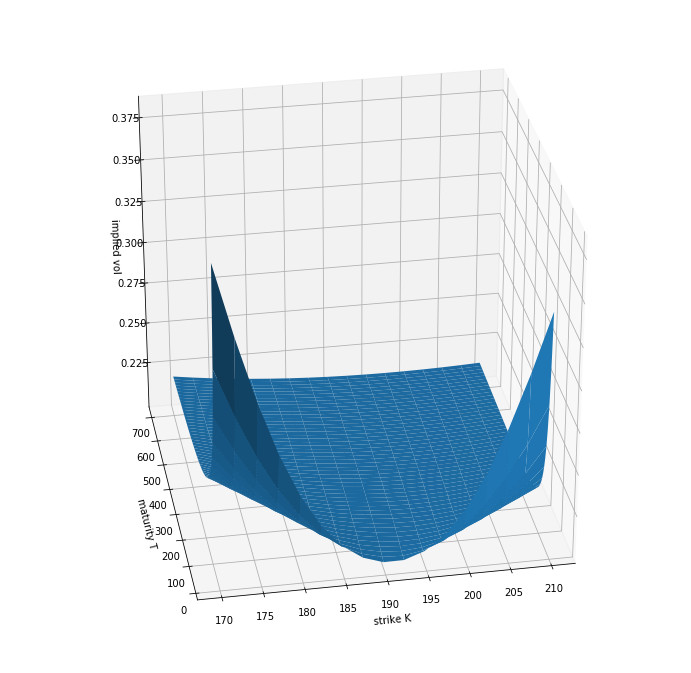

In [112]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, iv)
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('implied vol')
ax.view_init(30, 260)
plt.show()

**Append this surface to global chart with all 4 Volatility surfaces**

In [133]:
fig = py.get_figure('https://plot.ly/~friedrichz/674')
piv = go.Surface(x=strikes, y=maturities,z=iv.tolist(), colorscale='Portland', showscale=False, opacity=0.5)

data = [ piv ]
py.plot(data, filename='4-Vol-Surfaces', fileopt='append')

'https://plot.ly/~friedrichz/674'

# III. Local Volatility Surface

** Explicitly compute local volatility for each point in our grid **

In [115]:
deltaK = 2.5
deltaT = 1/52 
modelPrices = modelPrices_MN

## a.) Local Vol in single function

In [135]:
def local_vol_surface(modelPrices,maturities,strikes,r,q,deltaK,deltaT):
    modelPrices_df = pd.DataFrame(modelPrices, columns = strikes)
    
    # dC/dT for every point on the grid
    dcdt_2 = np.zeros((lenT, lenK))
    dcdt_2 = pd.DataFrame(dcdt_2)
    for i in modelPrices_df.index: 
        try:
            dcdt_2.iloc[i] = np.array((modelPrices_df.iloc[i+1] - modelPrices_df.iloc[i]) / deltaT)
        except:
            dcdt_2.iloc[i] = np.repeat(np.nan, len(modelPrices_df.columns))
            
    # dC/dK for every point on the grid
    dcdK_2 = pd.DataFrame()
    for i in range(len(modelPrices_df.columns)): 
        try:
            dcdK_2[modelPrices_df.columns[i]] = (modelPrices_df[modelPrices_df.columns[i+1]] - modelPrices_df[modelPrices_df.columns[i-1]])/(deltaK*2)
        except: 
            dcdK_2[modelPrices_df.columns[i]] = np.repeat(np.nan, len(modelPrices_df))
    
    dcdK_2[modelPrices_df.columns[0]] = np.repeat(np.nan, len(modelPrices_df))
    
    # For vol surface calculation
    dcdK_v2 = dcdK_2
    for i in modelPrices_df.columns:
        dcdK_v2[i] = i * dcdK_2[i]*(r-q)
        
    # For d2C/dK2: - 2*v_j,k
    modelPrices_df_neg2 = modelPrices_df*(-2)
    
    d2cdK2 = pd.DataFrame()
    for i in range(len(modelPrices_df.columns)): 
        try:
            d2cdK2[modelPrices_df.columns[i]] = (modelPrices_df[modelPrices_df.columns[i-1]] + modelPrices_df[modelPrices_df.columns[i+1]] -2* modelPrices_df[modelPrices_df.columns[i]])/(deltaK**2)
        except: 
            d2cdK2[modelPrices_df.columns[i]] = np.repeat(np.nan, len(modelPrices_df))
            
    modelPrices_df.shape == modelPrices_df_neg2.shape == d2cdK2.shape
    d2cdK2[modelPrices_df.columns[0]] = np.repeat(np.nan, len(modelPrices_df))
    
    # For vol surface calculation
    d2cdK2_v = d2cdK2
    for i in modelPrices_df.columns:
        d2cdK2_v[i] = i**2 * d2cdK2[i] * 1/2
    
    # Vol Surface 
    vol_surface = ((dcdt_2.values + dcdK_v2.values + q*modelPrices_df.values)/d2cdK2_v.values)**0.5    
    vol_surface[51] = vol_surface[52]
    
    fig = plt.figure(figsize=(12.,12.))
    ax = fig.add_subplot(111, projection='3d')
    X, Y = np.meshgrid(maturities, strikes)
    ax.plot_surface(X, Y, vol_surface.transpose())
    ax.set_xlabel('maturity T')
    ax.set_ylabel('strike K')
    ax.set_zlabel('local vol')
    ax.view_init(30, 150)
    plt.show()
    return vol_surface

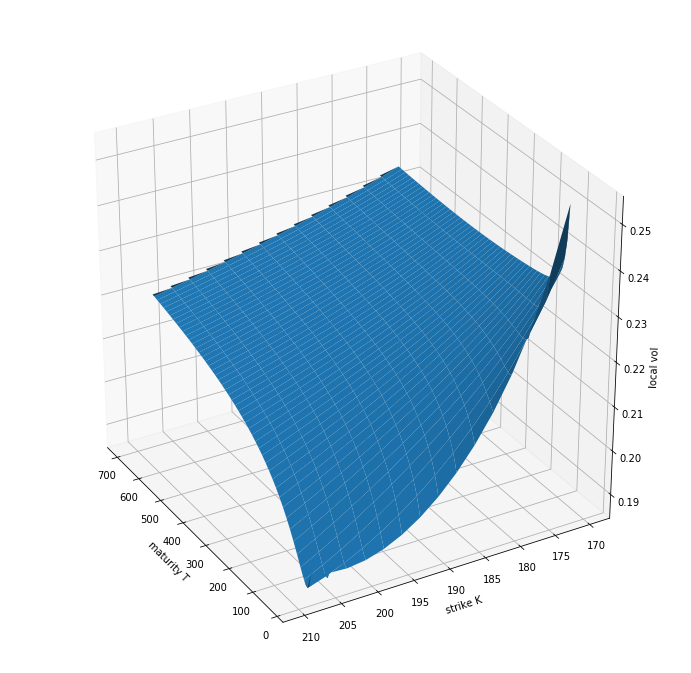

In [136]:
local_vol = local_vol_surface(modelPrices_MN,maturities,strikes,r,q,deltaK,deltaT)

**Append this surface to global chart with all 4 Volatility surfaces**

In [137]:
fig = py.get_figure('https://plot.ly/~friedrichz/674')
piv = go.Surface(x=strikes, y=maturities,z=local_vol.tolist(), colorscale='Portland', showscale=False, opacity=0.7)

data = [ piv ]
py.plot(data, filename='4-Vol-Surfaces', fileopt='append')

'https://plot.ly/~friedrichz/674'

## b.) Local Vol step by step (same result as above)

## 1. Calculate Finite differences

In [ ]:
# v_j,k Option prices for all points on the grid
modelPrices_df = pd.DataFrame(modelPrices, columns = strikes)
#modelPrices_df.head()

#### dC/dT for every point on the grid

In [8]:
dcdT = (modelPrices_df.diff()/deltaT).shift(-1)
#dcdT.head()

In [10]:
# ALTERNATIVE
dcdt_2 = np.zeros((lenT, lenK))
dcdt_2 = pd.DataFrame(dcdt_2)
for i in modelPrices_df.index: 
    try:
        dcdt_2.iloc[i] = np.array((modelPrices_df.iloc[i+1] - modelPrices_df.iloc[i]) / deltaT)
    except:
        dcdt_2.iloc[i] = np.repeat(np.nan, len(modelPrices_df.columns))

#### dC/dK for every point on the grid

In [11]:
dcdK = (modelPrices_df.diff(axis=1, periods = 2)/(2*deltaK)).shift(-1,axis=1)
#dcdK.head()

In [13]:
# ALTERNATIVE
dcdK_2 = pd.DataFrame()
for i in range(len(modelPrices_df.columns)): 
    try:
        dcdK_2[modelPrices_df.columns[i]] = (modelPrices_df[modelPrices_df.columns[i+1]] - modelPrices_df[modelPrices_df.columns[i-1]])/(deltaK*2)
    except: 
        dcdK_2[modelPrices_df.columns[i]] = np.repeat(np.nan, len(modelPrices_df))

In [14]:
dcdK_2[modelPrices_df.columns[0]] = np.repeat(np.nan, len(modelPrices_df))
# For vol surface calculation
dcdK_v2 = dcdK_2
for i in modelPrices_df.columns:
    dcdK_v2[i] = i * dcdK_2[i]*(r-q)

In [15]:
# For vol surface calculation
dcdK_v = dcdK
for i in modelPrices_df.columns:
    dcdK_v[i] = i * dcdK[i]*(r-q)

#### d2C/dK2 for every point on the grid

In [18]:
# For d2C/dK2: - 2*v_j,k
modelPrices_df_neg2 = modelPrices_df*(-2)

In [19]:
#modelPrices_df_neg2.head()

In [20]:
d2cdK2 = pd.DataFrame()
for i in range(len(modelPrices_df.columns)): 
    try:
        d2cdK2[modelPrices_df.columns[i]] = (modelPrices_df[modelPrices_df.columns[i-1]] + modelPrices_df[modelPrices_df.columns[i+1]] -2* modelPrices_df[modelPrices_df.columns[i]])/(deltaK**2)
    except: 
        d2cdK2[modelPrices_df.columns[i]] = np.repeat(np.nan, len(modelPrices_df))

In [21]:
modelPrices_df.shape == modelPrices_df_neg2.shape == d2cdK2.shape

True

In [22]:
d2cdK2[modelPrices_df.columns[0]] = np.repeat(np.nan, len(modelPrices_df))
#d2cdK2.head()

In [24]:
# For vol surface calculation
d2cdK2_v = d2cdK2
for i in modelPrices_df.columns:
    d2cdK2_v[i] = i**2 * d2cdK2[i] * 1/2

In [25]:
#d2cdK2_v.head()

In [27]:
dcdT.shape == modelPrices_df.shape == dcdK_v.shape == d2cdK2_v.shape

True

In [28]:
dcdt_2.shape == dcdK_v2.shape == modelPrices_df.shape == d2cdK2_v.shape

True

## 2. Calculate Local Volatility Surface

In [29]:
# Vol Surface 
vol_surface = ((dcdT + dcdK_v + q*modelPrices_df)/d2cdK2_v)**0.5

In [30]:
# ALTERNATIVE
vol_surface_2 = ((dcdt_2.values + dcdK_v2.values + q*modelPrices_df.values)/d2cdK2_v.values)**0.5

In [31]:
vol_surface_2[51] = vol_surface_2[52]

## 3. Plot Local Volatility Surface 

In [66]:
dataVOL = [go.Surface(z=vol_surface_2.tolist(), colorscale='Viridis')]
layout = go.Layout(
    width=800,
    height=700,
    autosize=False,
    title='Calibrated Local Vol Surface',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    )
)

fig = dict(data=dataVOL, layout=layout)
py.iplot(fig, filename='local-vol-surface')

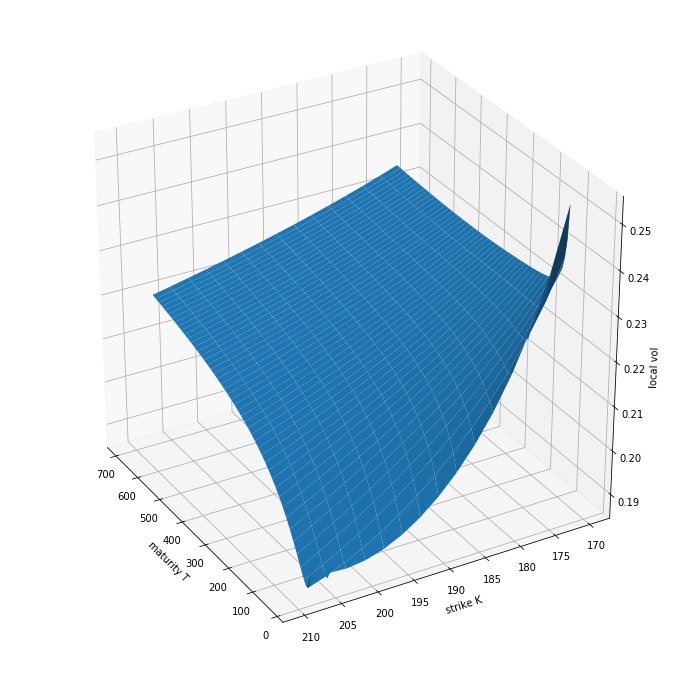

In [33]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(maturities, strikes)
ax.plot_surface(X, Y, vol_surface_2.transpose())
ax.set_xlabel('maturity T')
ax.set_ylabel('strike K')
ax.set_zlabel('local vol')
ax.view_init(30, 150)
plt.show()

# -- Testing --

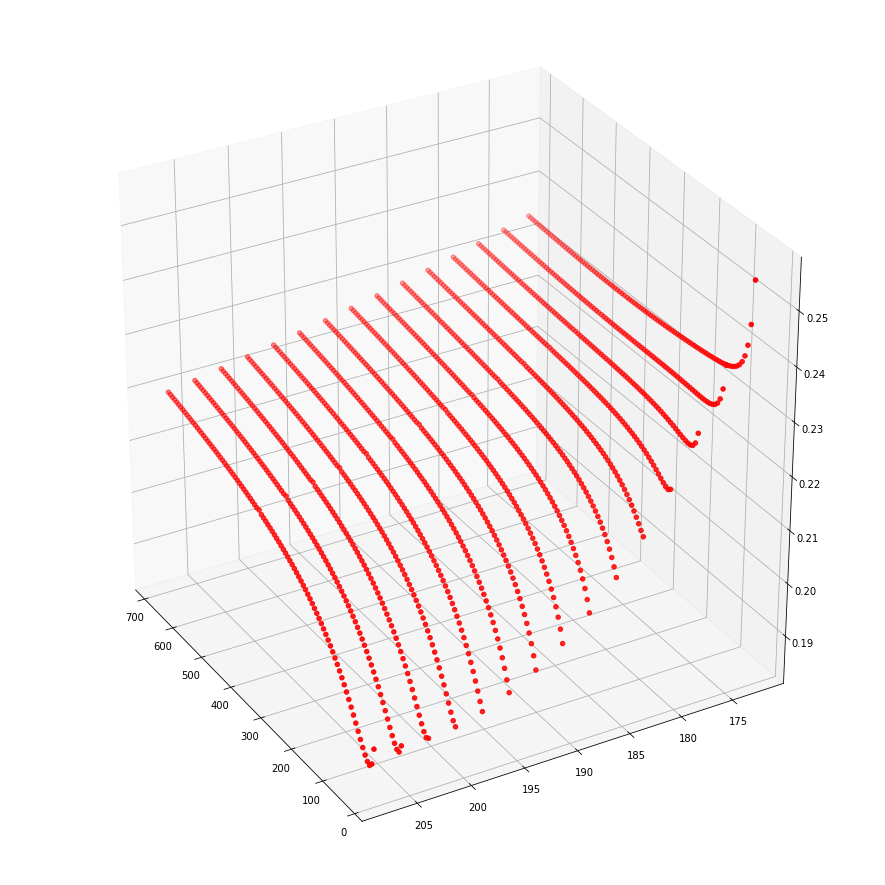

In [34]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
ax = axes3d.Axes3D(fig)
ax.scatter3D(X, Y, vol_surface_2.transpose(), c='r')
ax.view_init(30, 150)
plt.show()

In [32]:
import scipy as sp
import scipy.interpolate

In [33]:
data_size = 50
x = np.array([np.random.rand() for p in range(0,data_size)])
y = np.array([np.random.rand() for p in range(0,data_size)])
z = 2*x*x*x + np.sqrt(y)*y + np.random.rand()

In [34]:
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.scatter3D(x,y,z, c='r')
ax.view_init(30, 200)

NameError: name 'axes3d' is not defined

<Figure size 720x432 with 0 Axes>

In [35]:
vol_surface_2[:-1,1:-1].shape

(95, 15)

In [36]:
z = vol_surface_2[:-1,1:-1].flatten('F')

In [37]:
x = np.repeat(strikes[1:-1], len(maturities[:-1]))

In [38]:
y = np.tile(maturities[:-1],len(strikes[1:-1]))

In [39]:
x.shape == y.shape == z.shape

True

In [40]:
spline = sp.interpolate.Rbf(x,y,z,function='multiquadric',smooth=5, episilon=5)

In [42]:
spline.A

array([[ -4.        ,   2.00681691,   3.62067072, ..., 160.55997756,
        162.29733347, 164.03474369],
       [  2.00681691,  -4.        ,   2.00681691, ..., 158.82267774,
        160.55997756, 162.29733347],
       [  3.62067072,   2.00681691,  -4.        , ..., 157.08543588,
        158.82267774, 160.55997756],
       ...,
       [160.55997756, 158.82267774, 157.08543588, ...,  -4.        ,
          2.00681691,   3.62067072],
       [162.29733347, 160.55997756, 158.82267774, ...,   2.00681691,
         -4.        ,   2.00681691],
       [164.03474369, 162.29733347, 160.55997756, ...,   3.62067072,
          2.00681691,  -4.        ]])

In [48]:
x_grid = np.linspace(170, 210, 10*len(x))
y_grid = np.linspace(25, 691, 10*len(y))
B1, B2 = np.meshgrid(x_grid, y_grid, indexing='xy')
Z = np.zeros((x.size, z.size))

In [ ]:
Z = spline(B1,B2)
fig = plt.figure(figsize=(10,6))
ax = axes3d.Axes3D(fig)
ax.plot_wireframe(B1, B2, Z)
ax.plot_surface(B1, B2, Z,alpha=0.2)
ax.scatter3D(x,y,z, c='r')

In [271]:
x = x[:-1]

In [8]:
x_data = np.array([0.24626875, 0.23605962, 0.22766141, 0.22058236, 0.21451458,
       0.20926018, 0.20468884, 0.20071319, 0.19727429, 0.19433304,
       0.19186497, 0.18985721, 0.18830674, 0.18721957, 0.1866106,0.19433304,0.20071319,0.22058236,0.22058236,0.22058236,0.22058236,0.22058236])
#y_data = np.array([2, 0, 3, 7, 13])

n = len(x_data)
polydeg = 3           # Degree of polygons of parametric curve
w = ones(n)           # Set weights for knot points
w[0] = w[-1] = 1e6

t = np.linspace(0, 5, len(x_data))

x_params = np.polyfit(tt, x_data,4)
#y_params = np.polyfit(tt, y_data, 2)

x = np.poly1d(x_params)
#t = np.arange(0, 5, 0.1)

NameError: name 'tt' is not defined

In [406]:
print(x)

            4            3           2
-0.0008235 x + 0.007862 x - 0.01583 x - 0.01819 x + 0.2422


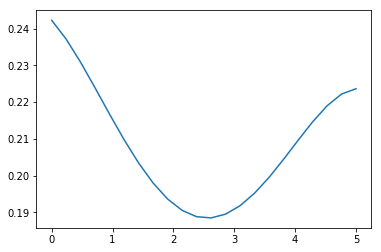

In [382]:
plt.plot(t, x(t))

In [3]:
def pol(x): 
    return ((-0.00082347*x**4 + 0.00786172*x**3 -0.01582862*x**2 -0.01818996*x)*np.exp(0) + 0.24224624  

In [448]:
def pol1(x): 
    return ((-0.00082347*x**4) + 0.00786172*x**3 -0.01582862*x**2 -0.01818996*x)*np.exp(-1/(x)*1.75) + 0.24224624  

In [81]:
def middle(x):
    x1 = 2
    am = 0.01582862
    bm = 0.01818996
    clmr = 0.24224624
    
    ar = -0.001
    br = 0.001
    cr = 0.02118996
    
    al = -ar
    bl = -br
    cl = -cr
    
    f = np.array([])
    for i in x: 
        if (i <= -x1):
            f =np.append(f,al*(i+x1)**3 + bl*(i+x1)**2 + cl*(i+x1)+ clmr)
        elif (i <= x1) and (i > -x1):
            f =np.append(f, am*(i-x1)**2 + bm*(i-x1) + clmr)
        elif i > x1:
            f =np.append(f,ar*(i-x1)**3 + br*(i-x1)**2 + cr*(i-x1)+ clmr)
        else:
            f =np.append(f,0)
    return f

In [449]:
def param(x, a=0.5, b=0.035):
    x1 = 0.05
    x2 = 0.15
    ######### 7 PARAMETERS #########
    amr = a
    bmr = b #0.008 #0.005 -> Determines where the center will be !!
    cmr = 0.2
        
    ar = 2
    arr= -1.3
    
    al = -2.5
    alL = 1.1
    
    ######### DERIVED PARAMS #########
    # - #
    aml = amr #0.15
    bml = -4*amr*x1+bmr
    cml = amr*x1**2-bmr*x1+cmr-aml*x1**2-bml*x1
    
    bl = aml
    cl = bml
    dl = cml
    
    bll= (6*al*(-x2+x1)+2*bl)/2 
    cll= 3*al*(-x2+x1)**2 + 2*bl*(-x2+x1) + cl
    dll= al*(-x2+x1)**3 + bl*(-x2+x1)**2 + cl*(-x2+x1) + dl   
    
    # + #
    br = amr
    brr= (6*ar*(x2-x1)+2*br)/2
    cr = bmr
    crr= 3*(x2-x1)**2 + 2*br*(x2-x1) + cr
    dr = cmr
    drr= ar*(x2-x1)**3 + br*(x2-x1)**2 + cr*(x2-x1) + dr
    
    f = np.array([])
    for i in x:
        # -
        if (i >= -x1) and (i < 0):
            ml = aml*(i+x1)**2 + bml*(i+x1) + cml
            f =np.append(f, ml)              
        elif (i >= -x2) and (i < -x1): 
            l = al*(i+x1)**3 + bl*(i+x1)**2 + cl*(i+x1) + dl
            f =np.append(f, l)            
        elif (i < -x2): 
            ll = alL*(i+x2)**3 + bll*(i+x2)**2 + cll*(i+x2) + dll
            f =np.append(f, ll)
            
        # +
        elif (i <= x1) and (i >= 0):
            mr = amr*(i-x1)**2 + bmr*(i-x1) + cmr
            f =np.append(f, mr)
        elif (i <= x2) and (i > x1):
            r = ar*(i-x1)**3 + br*(i-x1)**2 + cr*(i-x1) + dr
            f =np.append(f,r)
        elif (i > x2):
            rr = arr*(i-x2)**3 + brr*(i-x2)**2 + crr*(i-x2) + drr
            f =np.append(f,rr)
        else:
            f =np.append(f,0)
    #print(bml)
    return f        

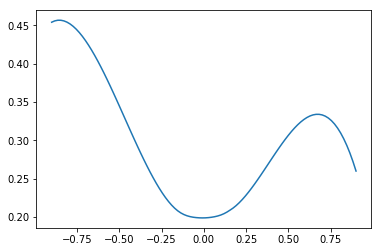

In [450]:
t = np.linspace(-0.9, 0.9, 100)
plt.plot(t, param(t, 0.3,0.035))
plt.show()

In [253]:
param([-.05])

-0.065


array([0.2015])

In [254]:
param([.05])

-0.065


array([0.2])

In [ ]:
def t_decay(x,T, nu): # x is moneyness
    return np.exp(1/((np.exp(x))*nu)*T)

In [346]:
np.log(1)

0.0

In [558]:
def vol_function(strikes, maturities,l1,l2,S0, a=0.5, b=0.035):
    x1 = np.log(l1/S0) # np.log(K0/S0) = 0.05 = np.log(190/180) roughly
    x2 = np.log(l2/S0) # np.log(210/180)
    ######### T-Axis PARAMETERS ############
    nu1 = -0.5
    nu2 = -0.5
    nu3 = 0.01
    nu4 = -0.5
    nu5 = -0.5
    nu6 = -0.99
    nu7 = -0.99
    
    ######### SETUP SURFACE ############
    lenT = len(maturities)
    lenK = len(strikes)
    volSurface = np.zeros((lenT, lenK))
    for i in range(lenT):
        T = maturities[i]
        ######### K-Axis PARAMETERS ############ need to decay with time
        amr = a *np.exp(nu1*T)
        bmr = b *np.exp(nu2*T)                      #0.008 #0.005 -> Determines where the center will be !!
        cmr = 0.15 *np.exp(nu3*T)

        ar = 178 *np.exp(nu4*T)
        arr= 1 *np.exp(nu5*T)

        al = -180.5 *np.exp(nu6*T)
        a1l = -1 *np.exp(nu7*T)
        ######### DERIVED PARAMS #########
        # - #
        aml = amr #0.15
        bml = -4*amr*x1+bmr
        cml = amr*x1**2-bmr*x1+cmr-aml*x1**2-bml*x1

        bl = aml
        cl = bml
        dl = cml

        # + #
        br = amr
        cr = bmr
        dr = cmr
        
        ######## EXP #########
        l_x2 =  al*(-x2+x1)**3 + bl*(-x2+x1)**2 + cl*(-x2+x1) + dl
        l1_x2 =  3*al*(-x2+x1)**2 + 2*bl*(-x2+x1) + cl
        l2_x2 =  6*al*(-x2+x1) + 2*bl  

        r_x2 =  ar*(x2-x1)**3 + br*(x2-x1)**2 + cr*(x2-x1) + dr
        r1_x2 =  3*ar*(x2-x1)**2 + 2*br*(x2-x1) + cr
        r2_x2 =  6*ar*(x2-x1) + 2*br
        
        c1l = solve_quadratic(l_x2,l1_x2,l2_x2)[0].real
        bll = (l_x2*a1l)/(l1_x2-l_x2*c1l)
        dll = (np.log(l_x2)-np.log(bll))/c1l

        crr = solve_quadratic(r_x2,r1_x2,r2_x2)[0].real
        brr = (r_x2*arr)/(r1_x2-r_x2*crr) 
        drr = (np.log(r_x2)-np.log(brr))/crr

        for j in range(lenK):
            x = np.log(strikes[j]/S0) 
            # -
            if (x >= -x1) and (x < 0):
                ml = aml*(x+x1)**2 + bml*(x+x1) + cml
                volSurface[i,j] = ml             
            elif (x >= -x2) and (x < -x1): 
                l = al*(x+x1)**3 + bl*(x+x1)**2 + cl*(x+x1) + dl
                volSurface[i,j] = l         
            elif (x < -x2): 
                ll = (a1l*(x+x2)+bll)*np.exp(c1l*((x+x2)+dll))
                volSurface[i,j] = ll
                
            # +
            elif (x <= x1) and (x >= 0):
                mr = amr*(x-x1)**2 + bmr*(x-x1) + cmr
                volSurface[i,j] = mr
            elif (x <= x2) and (x > x1):
                r = ar*(x-x1)**3 + br*(x-x1)**2 + cr*(x-x1) + dr
                volSurface[i,j] = r 
            elif (x > x2):
                rr = (arr*(x-x2)+brr)*np.exp(crr*((x-x2) + drr))
                volSurface[i,j] = rr
            else:
                volSurface[i,j] = 0
    return volSurface           

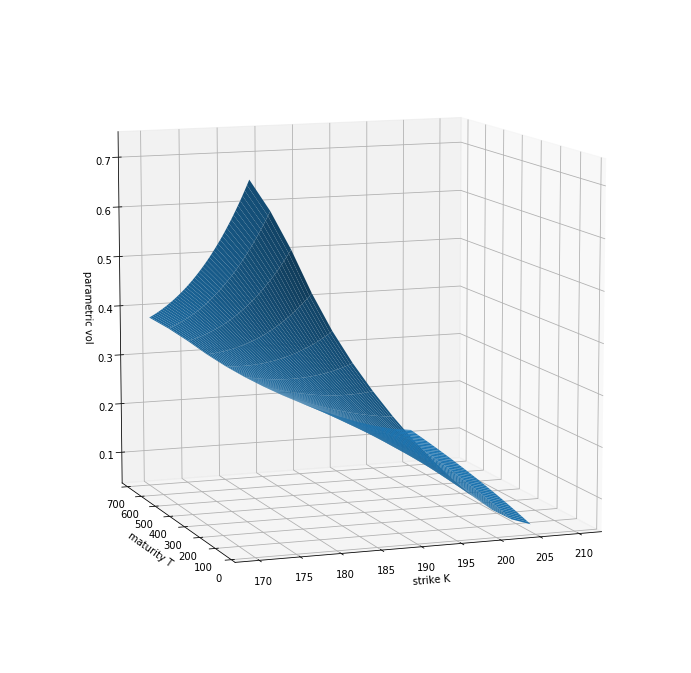

In [559]:
fig = plt.figure(figsize=(12.,12.))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(strikes, maturities)
ax.plot_surface(X, Y, vol_function(strikes,maturities/365,195,205,190,a=10,b=-3))
ax.set_xlabel('strike K')
ax.set_ylabel('maturity T')
ax.set_zlabel('parametric vol')
ax.view_init(10, 250)
plt.show()

In [283]:
# Start with Hyperplane
def vol_function(strikes,K0,S0,maturities, params_vol):
    a = params_vol[0]
    b = params_vol[1]
    c = params_vol[2]
    d = params_vol[3]
    e = params_vol[4]
    nu = params_vol[5]
    
    lenT = len(maturities)
    lenK = len(strikes)
    volSurface = np.zeros((lenT, lenK))
    #print(volSurface.shape)
    
    for i in range(lenT):
        for j in range(lenK):
            T = maturities[i]
            K = strikes[j]
            #volSurface[i,j] = (a*(K-K0) + b*T + c)
            volSurface[i,j] = ((a*np.log(K/S0)**4 + b*np.log(K/S0)**3 + c*np.log(K/S0)**2 + d*np.log(K/S0))*np.exp(1/((K/S0)*nu)*T) + e)
                              #((-0.00082347*x**4) + 0.00786172*x**3 -0.01582862*x**2 -0.01818996*x)*np.exp(-1.75) + 0.24224624 
    return volSurface
    #return np.exp(-nu*T)*(a*(K-K0)**3 + b*(K-K0)**2 + c*(K-K0) + d)

In [498]:
def expo(x):
    x2 = 0.15
    a = -1 #0.01582862
    b = 0.5
    c = 0.8
    d = 0.100
    f = np.array([])
    for i in x:
        if i <= -x2:
            f = np.append(f,(a*(i+x2)+b)*np.exp(c*((i+x2)+d)))
        else:
            f = np.append(f,0)
    return f

<function matplotlib.pyplot.show(*args, **kw)>

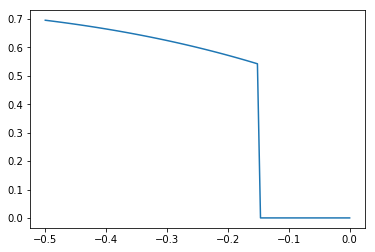

In [499]:
t = np.linspace(-0.5, 0, 100)
plt.plot(t, expo(t))
plt.show

In [522]:
def param_exp(x, a=0.5, b=0.035):
    x1 = 0.05
    x2 = 0.15
    ######### 7 PARAMETERS #########
    amr = a
    bmr = b #0.008 #0.005 -> Determines where the center will be !!
    cmr = 0.2
        
    ar = 2
    arr= 1 
    
    al = -2.5
    a1l = -1
    
    ######### DERIVED PARAMS #########
    # - #
    aml = amr #0.15
    bml = -4*amr*x1+bmr
    cml = amr*x1**2-bmr*x1+cmr-aml*x1**2-bml*x1
    
    bl = aml
    cl = bml
    dl = cml
    
    # + #
    br = amr
    cr = bmr
    dr = cmr
    
    ######## EXP #########
    l_x2 =  al*(-x2+x1)**3 + bl*(-x2+x1)**2 + cl*(-x2+x1) + dl
    l1_x2 =  3*al*(-x2+x1)**2 + 2*bl*(-x2+x1) + cl
    l2_x2 =  6*al*(-x2+x1) + 2*bl  
    
    r_x2 =  ar*(x2-x1)**3 + br*(x2-x1)**2 + cr*(x2-x1) + dr
    r1_x2 =  3*ar*(x2-x1)**2 + 2*br*(x2-x1) + cr
    r2_x2 =  6*ar*(x2-x1) + 2*br
    
    #print([r_x2,r1_x2,r2_x2])
    #print(solve_quadratic(r_x2,r1_x2,r2_x2))
    c1l = solve_quadratic(l_x2,l1_x2,l2_x2)[0].real
    bll = (l_x2*a1l)/(l1_x2-l_x2*c1l)
    dll = (np.log(l_x2)-np.log(bll))/c1l
    
    crr = solve_quadratic(r_x2,r1_x2,r2_x2)[0].real
    brr = (r_x2*arr)/(r1_x2-r_x2*crr)
    drr = (np.log(r_x2)-np.log(brr))/crr
    
    f = np.array([])
    for i in x:
        # -
        if (i >= -x1) and (i < 0):
            ml = aml*(i+x1)**2 + bml*(i+x1) + cml
            f =np.append(f, ml)              
        elif (i >= -x2) and (i < -x1): 
            l = al*(i+x1)**3 + bl*(i+x1)**2 + cl*(i+x1) + dl
            f =np.append(f, l)            
        elif (i < -x2): 
            ll = (a1l*(i+x2)+bll)*np.exp(c1l*((i+x2)+dll))
            f =np.append(f, ll)          
        # +
        elif (i <= x1) and (i >= 0):
            mr = amr*(i-x1)**2 + bmr*(i-x1) + cmr
            f =np.append(f, mr)
        elif (i <= x2) and (i > x1):
            r = ar*(i-x1)**3 + br*(i-x1)**2 + cr*(i-x1) + dr
            f =np.append(f,r)
        elif (i > x2):
            rr = (arr*(i-x2)+brr)*np.exp(crr*((i-x2) + drr))
            f =np.append(f,rr)
        else:
            f =np.append(f,0)
    return f  

In [471]:
param([0.15], 0.3,0.035) # r(x2)
6*(a)

1.263

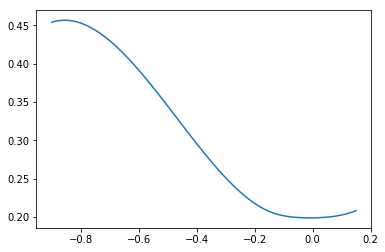

In [466]:
t = np.linspace(-0.9, 0.15, 100)
plt.plot(t, param(t, 0.3,0.035))
plt.show()

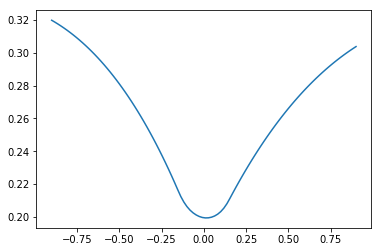

In [523]:
t = np.linspace(-0.9,0.9,100)
plt.plot(t, param_exp(t, a=0.5, b=0.035))
plt.show()

In [460]:
a = 0.2105
b = 2*0.8
c = 0.1
delta = (b**2) - (4*a*c)
solution1 = (-b-cmath.sqrt(delta))/(2*a)
solution2 = (-b+cmath.sqrt(delta))/(2*a)

In [452]:
param([0.15], a=0.5, b=0.035)

array([0.2105])

In [483]:
import cmath

def solve_quadratic(a, b, c):
    """
    Given three real coefficients,
    returns the (real) roots of the second degree polynomial
    """
    negative_b = -b
    determinant = b**2 - 4*a*c

    if a == 0.:
        return [float(-c)/b]
    else:
        root_determinant = cmath.sqrt(determinant)
        two_a = 2*a
        answers = [(negative_b - root_determinant)/two_a]
        if determinant:
            answers.append((negative_b + root_determinant)/two_a)
        return answers

In [465]:
solve_quadratic(0.2105, 2*0.8, 0.1)

[-7.537927573403843, -0.06302254536100346]

<function matplotlib.pyplot.show(*args, **kw)>

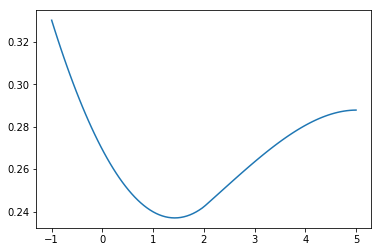

In [211]:
t = np.linspace(-1, 5, 100)
plt.plot(t, middle(t))
#plt.plot(t, expo(t))
plt.show

In [ ]:
def vol_curve(x):
    clmr = 0.24224624
    
    l = al*(x+x1)**3 + bl*(x+x1)**2 + cl*(x+x1) + clmr
    m = am*(x-x1)**2 + bm*(x-x1) + clmr
    r = ar*(x-x1)**3 + br*(x-x1)**2 + cr*(x-x1) + clmr
    

In [86]:
np.linspace(-5, 5, 10)

array([-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
        0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ])

In [83]:
from scipy.interpolate import CubicSpline

In [110]:
x1 = np.array([0.24626875, 0.23605962, 0.22766141, 0.22058236, 0.21451458,
       0.20926018, 0.20468884, 0.20071319, 0.19727429, 0.19433304,
       0.19186497, 0.18985721, 0.18830674, 0.18721957, 0.1866106 ])

In [212]:
x1 = middle(t)

In [217]:
x1 =np.array([0.33013394,0.28266482, 0.24541939, 0.2398849, 0.24174986, 0.2571622, 0.27156532, 0.28178317])

In [222]:
# calculate 5 natural cubic spline polynomials for 6 points
# (x,y) = (0,12) (1,14) (2,22) (3,39) (4,58) (5,77)
x = np.linspace(-1, 5, len(x1))
y = x1
# calculate natural cubic spline polynomials
cs = CubicSpline(x,y,bc_type='natural')

In [225]:
cs(np.linspace(-1, 5, 100))

array([0.33013394, 0.32673988, 0.32334695, 0.3199563 , 0.31656905,
       0.31318634, 0.30980931, 0.30643909, 0.30307682, 0.29972363,
       0.29638066, 0.29304904, 0.28972991, 0.2864244 , 0.28313366,
       0.27986036, 0.27661686, 0.27341914, 0.27028321, 0.26722508,
       0.26426077, 0.26140626, 0.25867759, 0.25609074, 0.25366174,
       0.25140658, 0.24934128, 0.24748184, 0.24584427, 0.24444242,
       0.24326889, 0.24230423, 0.24152884, 0.24092313, 0.24046751,
       0.24014239, 0.23992817, 0.23980527, 0.23975409, 0.23975504,
       0.23978852, 0.23983495, 0.23987474, 0.23988923, 0.23987565,
       0.23984441, 0.23980629, 0.23977209, 0.23975261, 0.23975864,
       0.23980098, 0.23989042, 0.24003777, 0.24025381, 0.24054935,
       0.24093518, 0.24142209, 0.2420206 , 0.24273197, 0.24354632,
       0.24445309, 0.24544174, 0.2465017 , 0.24762244, 0.24879339,
       0.250004  , 0.25124373, 0.25250202, 0.25376832, 0.25503207,
       0.25628273, 0.25750979, 0.25870649, 0.2598727 , 0.26100

<function matplotlib.pyplot.show(*args, **kw)>

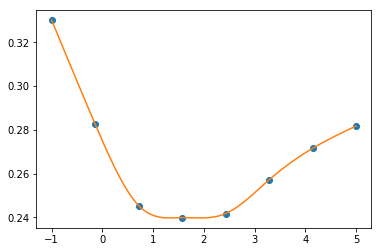

In [228]:
plt.plot(x, y, 'o', label='data')
plt.plot(np.linspace(-1, 5, 100), cs(np.linspace(-1, 5, 100)), label="S")
plt.show

In [236]:
cs.c

array([[ 8.50004024e-04,  1.19848209e-02, -1.46683306e-02,
         8.08275588e-03, -7.90000776e-03,  4.01933484e-04,
         1.24882405e-03],
       [-1.62630326e-17,  2.18572463e-03,  3.30038356e-02,
        -4.71472884e-03,  1.60695006e-02, -4.24480510e-03,
        -3.21126185e-03],
       [-5.60051328e-02, -5.41316545e-02, -2.39691743e-02,
         2.78631557e-04,  1.00112930e-02,  2.01467463e-02,
         1.37558318e-02],
       [ 3.30133940e-01,  2.82664820e-01,  2.45419390e-01,
         2.39884900e-01,  2.41749860e-01,  2.57162200e-01,
         2.71565320e-01]])

In [237]:
cs.c.item(3,0)

0.33013394